In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting,datasets
import pandas as pd
%matplotlib inline
niimg = datasets.load_mni152_template()
import matplotlib.image as mpimg
import networkx as nx
import h5py as h5
import torch

In [2]:
#schaefer 116 coordinates
subcortical_coords = np.loadtxt('../data/external/Tian_Subcortex_S1_3T_COG.txt')
Schaefer100 = pd.read_csv('../data/external/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
cortical_coords = np.array(Schaefer100[['R','A','S']])
SchaeferTian116_coords = np.concatenate((np.array(subcortical_coords),cortical_coords),axis=0)

networks_names = ['Subcortical','Visual','Somatomotor','Dorsal attention','Salience ventral attention','Limbic','Control','Default mode']
networks_colors = ['black','red','blue','green','purple','orange','brown','pink']
networks_order = [0,1,2,3,4,5,6,7,1,2,3,4,5,6,7]
networks_number_of_rois_hemisphere = [16,9,6,8,7,3,4,13,
                           8,8,7,5,2,9,11]
networks_number_of_rois2 = [16,17,14,15,12,5,13,24]

network_indices = [] # indicates indices from the Schaefer 116 atlas into a label where networks are put together
network_indices2 = [] #indicates the indices in each network after relabeling
network_indices3 = [] #indicates the yeo network each area belongs to

start1 = 0
start2 = 66
start3 = 0
#reorder such that the first left and right hemisphere are ordered together
for network in range(8):
    if network==0:
        tmp = np.concatenate((np.arange(start1,start1+networks_number_of_rois_hemisphere[network],step=2),
                                np.arange(start1+1,start1+networks_number_of_rois_hemisphere[network],step=2)))
        network_indices.append(tmp)
        start1 += networks_number_of_rois_hemisphere[network]
    else:
        network_index = np.where(np.array(networks_order)==network)[0]
        tmp = np.concatenate((np.arange(start1,start1+networks_number_of_rois_hemisphere[network_index[0]]),
                             np.arange(start2,start2+networks_number_of_rois_hemisphere[network_index[1]])))
        network_indices.append(tmp)
        start1 += networks_number_of_rois_hemisphere[network_index[0]]
        start2 += networks_number_of_rois_hemisphere[network_index[1]]
    network_indices2.append(np.arange(start3,start3+networks_number_of_rois2[network]))
    network_indices3.append(np.ones(networks_number_of_rois2[network])*network)
    start3 += networks_number_of_rois2[network]
network_indices_concat = np.concatenate(network_indices)
network_indices3 = np.concatenate(network_indices3).astype(int)

In [3]:
angles = np.array([0, 0.25, 0.5, 0.75, 1.0])  # Normalized positions of -pi to pi
colors = ['blue', 'green', 'red', 'yellow', 'blue']  # Color for each angle

# Create a custom colormap
cyclic_cmap = LinearSegmentedColormap.from_list('cyclic_map', list(zip(angles, colors)))

In [4]:
# make another colormap that is the second half of 'bwr'
bwr2 = plt.cm.bwr
colors_bwr2 = bwr2(np.linspace(0, 1, 256))
colors_bwr2 = colors_bwr2[128:]
cmap_bwr2 = LinearSegmentedColormap.from_list('bwr2', colors_bwr2)

In [ ]:
def plot_matrix(matrix, title, cmap='bwr',clim=(-0.5,0.5),show_boxes=True):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), gridspec_kw={'height_ratios': [10, 1], 'width_ratios': [1,10], 'wspace':-0.05, 'hspace':-0.15})
    plotting.plot_matrix(matrix, cmap=cmap, colorbar=False, axes=ax[0,1],vmin=clim[0],vmax=clim[1])
    # plotting.plot_matrix(matrix, cmap=cmap, colorbar=False, axes=ax[0,1])
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])
    # ax[0,1].set_title(title, fontsize=20)
    ax[1,0].axis('off')
    ax[1,1].axis('off')
    ax[0,0].axis('off')
    
    if show_boxes:
        # Create a 1D array that represents the colored boxes
        color_boxes = np.zeros((1, matrix.shape[0], 3))

        # Assign colors to the corresponding segments
        for i, color in enumerate(networks_colors):
            start = sum(networks_number_of_rois2[:i])
            end = start + networks_number_of_rois2[i]
            #use the predefined colors
            color_boxes[0, start:end, :] = plt.cm.colors.to_rgb(color)
            
        # Plot the color boxes below the matrix
        ax[0,0].imshow(np.swapaxes(color_boxes,0,1), aspect='auto')
        new_ax00_position = [ax[0,0].get_position().x0, ax[0,1].get_position().y0, ax[0,0].get_position().width*0.5, ax[0,1].get_position().height]
        ax[0,0].set_position(new_ax00_position)
        ax[1,1].imshow(color_boxes, aspect='auto')
        new_ax11_position = [ax[1,1].get_position().x0, ax[1,1].get_position().y0-0.025, ax[0,1].get_position().width, ax[1,1].get_position().height*0.5]
        ax[1,1].set_position(new_ax11_position)
    fig.savefig('figures_tmp/'+title+'.png',dpi=300,bbox_inches='tight')
    plt.close()
    return

def avg_matrix_in_networks(matrix, network_indices):
    avg_matrix = np.zeros((len(network_indices), len(network_indices)),dtype=matrix.dtype)
    for i, network1 in enumerate(network_indices):
        for j, network2 in enumerate(network_indices):
            avg_matrix[i, j] = np.mean(matrix[network1, :][:, network2])
    return avg_matrix

def get_Z(params,idx,sort=True,model='Watson'):
    if model in ['Watson','Complex_Watson']:
        Z = np.outer(params['mu'][:,idx],params['mu'][:,idx].conj())*np.sqrt(params['kappa'][idx])
    elif model in ['ACG','Complex_ACG','MACG']:
        M = params['M'][idx]
        o = np.linalg.norm(M,'fro')**2
        gamma = 1/(1+o/116)
        Z = gamma*(M@M.conj().T+np.eye(116))
    elif model in ['SingularWishart']:
        M = params['M'][idx]
        gamma = params['gamma'][idx]
        Z = M@M.T+gamma*np.eye(116)
    else:
        raise ValueError('Model not recognized')
    if sort:
        Z = Z[network_indices_concat,:][:,network_indices_concat]
    return Z

## Global coherence network

In [6]:
# global phase coherence without GSR
data_file = '../data/processed/REST1REST2fMRI_SchaeferTian116.h5'
num_subs = 255
with h5.File(data_file,'r') as f:
    data_train = f['U_complex_train'][:][:1200*num_subs]
Z_global = np.mean(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)
Z_global = Z_global[network_indices_concat,:][:,network_indices_concat]

c = 0.005
# c = 0.5
plot_matrix(np.real(Z_global), 'Global phase coupling, real',clim=(-c,c))
plot_matrix(np.imag(Z_global), 'Global phase coupling, imaginary',clim=(-c,c))
plot_matrix(np.abs(Z_global), 'Global phase coupling, magnitude',clim=(0,c),cmap=cmap_bwr2)
plot_matrix(np.angle(Z_global), 'Global phase coupling, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

In [7]:
# global phase coherence with GSR
data_file = '../data/processed/REST1REST2fMRI_SchaeferTian116_GSR.h5'
num_subs = 255
with h5.File(data_file,'r') as f:
    data_train = f['U_complex_train'][:][:1200*num_subs]
Z_global_GSR = np.mean(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)
# Z_global_std_GSR = np.std(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)
Z_global_GSR = Z_global_GSR[network_indices_concat,:][:,network_indices_concat]
# Z_global_std_GSR = Z_global_std_GSR[network_indices_concat,:][:,network_indices_concat]

c = 0.005
# c = 0.5
plot_matrix(np.real(Z_global_GSR), 'Global phase coupling, GSR, real',clim=(-c,c))
plot_matrix(np.imag(Z_global_GSR), 'Global phase coupling, GSR, imaginary',clim=(-c,c))
plot_matrix(np.abs(Z_global_GSR), 'Global phase coupling, GSR, magnitude',clim=(0,c),cmap=cmap_bwr2)
plot_matrix(np.angle(Z_global_GSR), 'Global phase coupling, GSR, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

In [8]:
# global phase amplitude coupling with GSR
data_file = '../data/processed/REST1REST2fMRI_SchaeferTian116_GSR.h5'
num_subs = 255
with h5.File(data_file,'r') as f:
    phase_train = f['U_complex_train'][:][:1200*num_subs]
    magn_train = f['A_train'][:][:1200*num_subs][:,:,None]
    data_train = phase_train*magn_train
Z_global_GSR = np.mean(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)
# Z_global_std_GSR = np.std(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)
Z_global_GSR = Z_global_GSR[network_indices_concat,:][:,network_indices_concat]
# Z_global_std_GSR = Z_global_std_GSR[network_indices_concat,:][:,network_indices_concat]

c = 2.5
# plot_matrix(np.real(Z_global_GSR), 'Global phase-amplitude coupling, GSR, real',clim=(-c,c))
# plot_matrix(np.imag(Z_global_GSR), 'Global phase-amplitude coupling, GSR, imaginary',clim=(-c,c))
plot_matrix(np.abs(Z_global_GSR), 'Global phase-amplitude coupling, GSR, magnitude',clim=(0,c),cmap=cmap_bwr2)
plot_matrix(np.angle(Z_global_GSR), 'Global phase-amplitude coupling, GSR, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

In [9]:
# global amplitude coupling with GSR
data_file = '../data/processed/REST1REST2fMRI_SchaeferTian116_GSR.h5'
num_subs = 255
with h5.File(data_file,'r') as f:
    data_train = f['timeseries_train'][:][:1200*num_subs]
Z_global_GSR = np.mean(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)
# Z_global_std_GSR = np.std(data_train@np.swapaxes(data_train.conj(),-2,-1),axis=0)
Z_global_GSR = Z_global_GSR[network_indices_concat,:][:,network_indices_concat]
# Z_global_std_GSR = Z_global_std_GSR[network_indices_concat,:][:,network_indices_concat]

c = 250
plot_matrix(Z_global_GSR, 'Global amplitude coupling, GSR',clim=(-c,c))
# plot_matrix(np.imag(Z_global_GSR), 'Global amplitude coupling, GSR, imaginary',clim=(-c,c))
# plot_matrix(np.abs(Z_global_GSR), 'Global amplitude coupling, GSR, magnitude',clim=(0,c),cmap=cmap_bwr2)
# plot_matrix(np.angle(Z_global_GSR), 'Global amplitude coupling, GSR, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

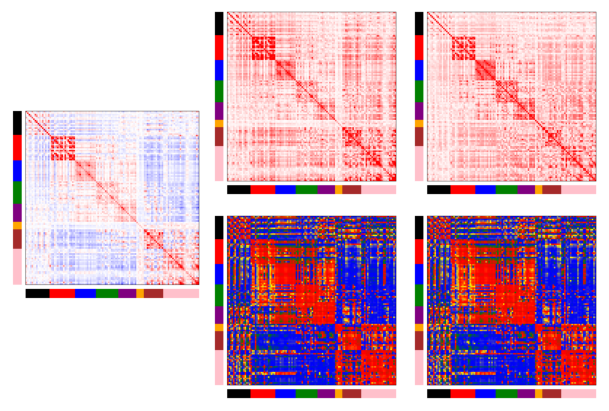

In [10]:
# amplitude vs phase-amplitude vs pahse

fig = plt.figure(figsize=(6,4),constrained_layout=True)
gs = fig.add_gridspec(2,3,width_ratios=[1,1,1],height_ratios=[1,1],hspace=0)
ax00 = fig.add_subplot(gs[:,0])
ax00.imshow(mpimg.imread('figures_tmp/Global amplitude coupling, GSR.png'))
ax00.axis('off')

ax01 = fig.add_subplot(gs[0,1])
ax01.imshow(mpimg.imread('figures_tmp/Global phase-amplitude coupling, GSR, magnitude.png'))
ax01.axis('off')

ax02 = fig.add_subplot(gs[1,1])
ax02.imshow(mpimg.imread('figures_tmp/Global phase-amplitude coupling, GSR, angle.png'))
ax02.axis('off')

ax10 = fig.add_subplot(gs[0,2])
ax10.imshow(mpimg.imread('figures_tmp/Global phase coupling, GSR, magnitude.png'))
ax10.axis('off')

ax11 = fig.add_subplot(gs[1,2])
ax11.imshow(mpimg.imread('figures_tmp/Global phase coupling, GSR, angle.png'))
ax11.axis('off')

fig.savefig('figures/Global_coupling.png',dpi=300,bbox_inches='tight')

## K1 solutions

In [11]:
# # #K1 Watson
clim = (-0.5,0.5)
clim2 = (0,0.5)
# print('Watson')
# params = np.load('../data/results/116_results/params/Watson_rank1_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,idx=0,model='Watson')
# plot_matrix(Z, 'Watson K=1',clim=clim)

# #K1 ACG rank 10
# print('ACG rank 10')
# params = np.load('../data/results/116_results/params/ACG_rank9_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,idx=0,model='ACG')
# plot_matrix(Z, 'ACG rank 10 K=1',clim=clim)

# #K1 ACG rank 25
# print('ACG rank 25')
# params = np.load('../data/results/116_results/params/ACG_rank25_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,idx=0,model='ACG')
# plot_matrix(Z, 'ACG rank 25 K=1',clim=clim)

# #K1 MACG rank 10
# print('MACG rank 10')
# params = np.load('../data/results/116_results/params/MACG_rank9_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,idx=0,model='MACG')
# plot_matrix(Z, 'MACG rank 10 K=1',clim=clim)

# #K1 MACG rank 25
# print('MACG rank 25')
# params = np.load('../data/results/116_results/params/MACG_rank25_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,idx=0,model='MACG')
# plot_matrix(Z, 'MACG rank 25 K=1',clim=clim)

# #K1 Singular Wishart rank 10
# print('Singular Wishart rank 10')
# params = np.load('../data/results/116_results/params/SingularWishart_rank9_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,idx=0,model='SingularWishart')
# plot_matrix(Z, 'Singular Wishart rank 10 K=1',clim=clim)

# #K1 Singular Wishart rank 25
# print('Singular Wishart rank 25')
# params = np.load('../data/results/116_results/params/SingularWishart_rank25_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,idx=0,model='SingularWishart')
# plot_matrix(Z, 'Singular Wishart rank 25 K=1',clim=clim)

# #K1 complex Watson 
# print('Complex Watson')
# params = np.load('../data/results/116_results/params/Complex_Watson_rank1_K1_params.npy', allow_pickle=True).item()
# Z = get_Z(params,idx=0,model='Complex_Watson')
# plot_matrix(np.real(Z), 'Complex Watson K=1, real',clim=clim)
# plot_matrix(np.imag(Z), 'Complex Watson K=1, imaginary',clim=clim)
# plot_matrix(np.abs(Z), 'Complex Watson K=1, magnitude',clim=clim2,cmap=cmap_bwr2)
# plot_matrix(np.angle(Z), 'Complex Watson K=1, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

#K1 complex ACG rank 1
params = np.load('../data/results/116_results/params/Complex_ACG_rank1_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='Complex_ACG')
plot_matrix(np.real(Z), 'Complex ACG rank 1 K=1, real',clim=clim)
plot_matrix(np.imag(Z), 'Complex ACG rank 1 K=1, imaginary',clim=clim)
plot_matrix(np.abs(Z), 'Complex ACG rank 1 K=1, magnitude',clim=clim2,cmap=cmap_bwr2)
plot_matrix(np.angle(Z), 'Complex ACG rank 1 K=1, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

#K1 complex ACG rank 10
print('Complex ACG rank 10')
params = np.load('../data/results/116_results/params/Complex_ACG_rank10_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='Complex_ACG')
plot_matrix(np.real(Z), 'Complex ACG rank 10, real',clim=clim)
plot_matrix(np.imag(Z), 'Complex ACG rank 10, imaginary',clim=clim)
plot_matrix(np.abs(Z), 'Complex ACG rank 10, magnitude',clim=clim2,cmap=cmap_bwr2)
plot_matrix(np.angle(Z), 'Complex ACG rank 10, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

#K1 complex ACG rank 25
print('Complex ACG rank 25')
params = np.load('../data/results/116_results/params/Complex_ACG_rank25_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='Complex_ACG')
plot_matrix(np.real(Z), 'Complex ACG rank 25, real',clim=clim)
plot_matrix(np.imag(Z), 'Complex ACG rank 25, imaginary',clim=clim)
plot_matrix(np.abs(Z), 'Complex ACG rank 25, magnitude',clim=clim2,cmap=cmap_bwr2)
plot_matrix(np.angle(Z), 'Complex ACG rank 25, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

#K1 complex ACG rank 100
print('Complex ACG rank 100')
params = np.load('../data/results/116_results/params/Complex_ACG_rank100_K1_params.npy', allow_pickle=True).item()
Z = get_Z(params,idx=0,model='Complex_ACG')
plot_matrix(np.real(Z), 'Complex ACG rank 100, real',clim=clim)
plot_matrix(np.imag(Z), 'Complex ACG rank 100, imaginary',clim=clim)
plot_matrix(np.abs(Z), 'Complex ACG rank 100, magnitude',clim=clim2,cmap=cmap_bwr2)
plot_matrix(np.angle(Z), 'Complex ACG rank 100, angle',clim=(-np.pi,np.pi),cmap=cyclic_cmap)

Complex ACG rank 10
Complex ACG rank 25
Complex ACG rank 100


## main paper fig

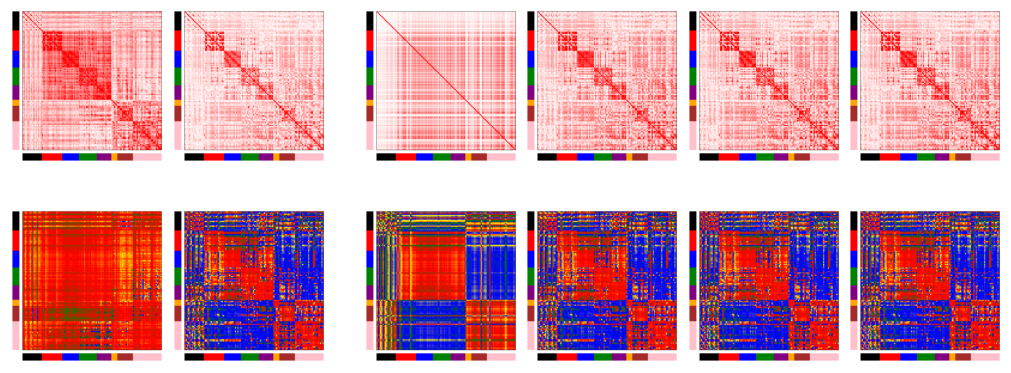

In [12]:
fig = plt.figure(figsize=(10,4),constrained_layout=True)
gs = fig.add_gridspec(2,7,width_ratios=[1,1,0.2,1,1,1,1],hspace=0)

ax00 = fig.add_subplot(gs[0,0])
ax00.imshow(mpimg.imread('figures_tmp/Global phase coupling, magnitude.png'))
ax00.axis('off')
ax10 = fig.add_subplot(gs[1,0])
ax10.imshow(mpimg.imread('figures_tmp/Global phase coupling, angle.png'))
ax10.axis('off')

ax01 = fig.add_subplot(gs[0,1])
ax01.imshow(mpimg.imread('figures_tmp/Global phase coupling, GSR, magnitude.png'))
ax01.axis('off')
ax11 = fig.add_subplot(gs[1,1])
ax11.imshow(mpimg.imread('figures_tmp/Global phase coupling, GSR, angle.png'))
ax11.axis('off')

ax30 = fig.add_subplot(gs[0,3])
ax30.imshow(mpimg.imread('figures_tmp/Complex ACG rank 1 K=1, magnitude.png'))
ax30.axis('off')
ax31 = fig.add_subplot(gs[1,3])
ax31.imshow(mpimg.imread('figures_tmp/Complex ACG rank 1 K=1, angle.png'))
ax31.axis('off')

ax40 = fig.add_subplot(gs[0,4])
ax40.imshow(mpimg.imread('figures_tmp/Complex ACG rank 10, magnitude.png'))
ax40.axis('off')
ax41 = fig.add_subplot(gs[1,4])
ax41.imshow(mpimg.imread('figures_tmp/Complex ACG rank 10, angle.png'))
ax41.axis('off')

ax50 = fig.add_subplot(gs[0,5])
ax50.imshow(mpimg.imread('figures_tmp/Complex ACG rank 25, magnitude.png'))
ax50.axis('off')
ax51 = fig.add_subplot(gs[1,5]) 
ax51.imshow(mpimg.imread('figures_tmp/Complex ACG rank 25, angle.png'))
ax51.axis('off')

ax60 = fig.add_subplot(gs[0,6])
ax60.imshow(mpimg.imread('figures_tmp/Complex ACG rank 100, magnitude.png'))
ax60.axis('off')
ax61 = fig.add_subplot(gs[1,6])
ax61.imshow(mpimg.imread('figures_tmp/Complex ACG rank 100, angle.png'))
ax61.axis('off')

fig.savefig('figures/Global_phase_coherence.png',dpi=300,bbox_inches='tight')

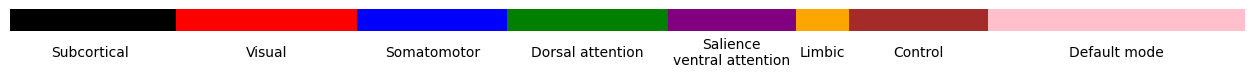

In [13]:
#let the first subplot show the 8 colored boxes vertically with the network names next to them
networks_names2 = ['Subcortical','Visual','Somatomotor','Dorsal attention','Salience\nventral attention','Limbic','Control','Default mode']
fig,ax = plt.subplots(1,1,figsize=(16,1))
color_boxes = np.zeros((116, 2, 3))
for i, color in enumerate(networks_colors):
    start = sum(networks_number_of_rois2[:i])
    end = start + networks_number_of_rois2[i]
    color_boxes[start:end,:, :] = plt.cm.colors.to_rgb(color)
ax.imshow(np.swapaxes(color_boxes,0,1), aspect='equal')
ax.set_xlim(0,116)
ax.axis('off')
for i in range(8):
    ax.text((sum(networks_number_of_rois2[:i])+networks_number_of_rois2[i]/2-0.5),3.5, networks_names2[i], ha='center', va='center',fontsize=10)
fig.savefig('figures/Networks_labels.png',dpi=300,bbox_inches='tight')

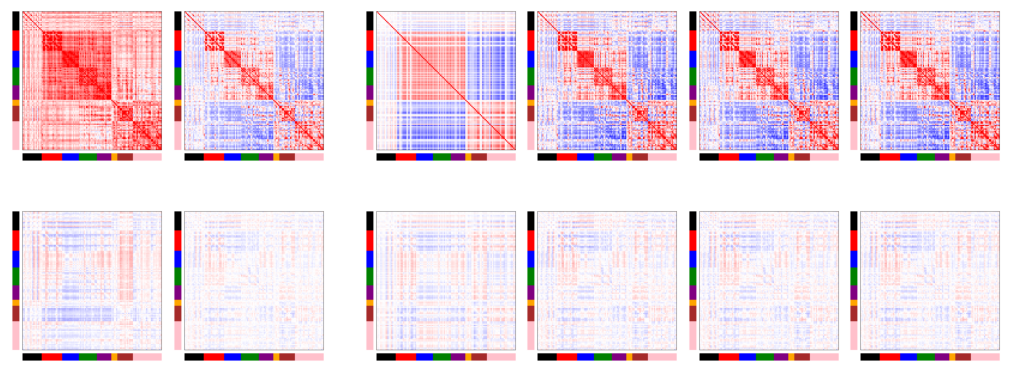

In [14]:
fig = plt.figure(figsize=(10,4),constrained_layout=True)
gs = fig.add_gridspec(2,7,width_ratios=[1,1,0.2,1,1,1,1],hspace=0)

ax00 = fig.add_subplot(gs[0,0])
ax00.imshow(mpimg.imread('figures_tmp/Global phase coupling, real.png'))
ax00.axis('off')
ax10 = fig.add_subplot(gs[1,0])
ax10.imshow(mpimg.imread('figures_tmp/Global phase coupling, imaginary.png'))
ax10.axis('off')

ax01 = fig.add_subplot(gs[0,1])
ax01.imshow(mpimg.imread('figures_tmp/Global phase coupling, GSR, real.png'))
ax01.axis('off')
ax11 = fig.add_subplot(gs[1,1])
ax11.imshow(mpimg.imread('figures_tmp/Global phase coupling, GSR, imaginary.png'))
ax11.axis('off')

ax30 = fig.add_subplot(gs[0,3])
ax30.imshow(mpimg.imread('figures_tmp/Complex ACG rank 1 K=1, real.png'))
ax30.axis('off')
ax31 = fig.add_subplot(gs[1,3])
ax31.imshow(mpimg.imread('figures_tmp/Complex ACG rank 1 K=1, imaginary.png'))
ax31.axis('off')

ax40 = fig.add_subplot(gs[0,4])
ax40.imshow(mpimg.imread('figures_tmp/Complex ACG rank 10, real.png'))
ax40.axis('off')
ax41 = fig.add_subplot(gs[1,4])
ax41.imshow(mpimg.imread('figures_tmp/Complex ACG rank 10, imaginary.png'))
ax41.axis('off')

ax50 = fig.add_subplot(gs[0,5])
ax50.imshow(mpimg.imread('figures_tmp/Complex ACG rank 25, real.png'))
ax50.axis('off')
ax51 = fig.add_subplot(gs[1,5]) 
ax51.imshow(mpimg.imread('figures_tmp/Complex ACG rank 25, imaginary.png'))
ax51.axis('off')

ax60 = fig.add_subplot(gs[0,6])
ax60.imshow(mpimg.imread('figures_tmp/Complex ACG rank 100, real.png'))
ax60.axis('off')
ax61 = fig.add_subplot(gs[1,6])
ax61.imshow(mpimg.imread('figures_tmp/Complex ACG rank 100, imaginary.png'))
ax61.axis('off')

fig.savefig('figures/Global_phase_coherence_realimag.png',dpi=300,bbox_inches='tight')

In [15]:
# fig,axs = plt.subplots(2,4,figsize=(10,6),layout='constrained')

# #let the first subplot show the 8 colored boxes vertically with the network names next to them
# color_boxes = np.zeros((5, 116, 3))
# for i, color in enumerate(networks_colors):
#     start = sum(networks_number_of_rois2[:i])
#     end = start + networks_number_of_rois2[i]
#     color_boxes[:, start:end, :] = plt.cm.colors.to_rgb(color)
# axs[0,0].imshow(np.swapaxes(color_boxes,0,1), aspect='equal')
# axs[0,0].set_xlim(-16,100)
# axs[0,0].axis('off')
# for i in range(8):
#     axs[0,0].text(10, (sum(networks_number_of_rois2[:i])+sum(networks_number_of_rois2[:i+1]))/2, networks_names[i], ha='left', va='center',fontsize=10)

# img = mpimg.imread('figures/Watson K=1.png')
# axs[0,1].imshow(img)
# axs[0,1].axis('off')

# img = mpimg.imread('figures/ACG rank 10 K=1.png')
# axs[0,2].imshow(img)
# axs[0,2].axis('off')

# img = mpimg.imread('figures/ACG rank 25 K=1.png')
# axs[0,3].imshow(img)
# axs[0,3].axis('off')

# img = mpimg.imread('figures/MACG rank 10 K=1.png')
# axs[1,0].imshow(img)
# axs[1,0].axis('off')

# img = mpimg.imread('figures/MACG rank 25 K=1.png')
# axs[1,1].imshow(img)
# axs[1,1].axis('off')

# img = mpimg.imread('figures/Singular Wishart rank 10 K=1.png')
# axs[1,2].imshow(img)
# axs[1,2].axis('off')

# img = mpimg.imread('figures/Singular Wishart rank 25 K=1.png')
# axs[1,3].imshow(img)
# axs[1,3].axis('off')

# fig.savefig('figures/116_results_K1_realmodels.png',dpi=300)

In [16]:
def plot_graph_yeo(color_matrix,linewidth_matrix, network_names):

    include_self_loop = 0 #0 means yes, 1 means no

    #make one networkx graph encoding both color and linewidth
    num_nodes = color_matrix.shape[0]
    if num_nodes == 8:
        linewidth_weight = 15
    else:
        linewidth_weight = 0.1
    # G_color = nx.from_numpy_array(color_matrix)
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    for i in range(num_nodes):
        for j in range(i+include_self_loop,num_nodes):
            weight = np.cos(color_matrix[i,j])
            # weight = (np.cos(color_matrix[i,j])+1)/2
            G.add_edge(i,j,weight=weight)
    # G_color[:][:]['color'] = color_matrix
    edge_weights = []
    for i in range(num_nodes):
        for j in range(i+include_self_loop,num_nodes):
            edge_weights.append(linewidth_matrix[i,j]*linewidth_weight)
    edge_colors = []
    for i in range(num_nodes):
        for j in range(i+include_self_loop,num_nodes):
            #map color_matrix[i,j] to a color in the cyclic colormap
            col = cyclic_cmap(((color_matrix[i,j]+np.pi)/(2*np.pi)*256).astype(int))
            edge_colors.append(col)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')
    pos = nx.circular_layout(G)
    if num_nodes==8:
        pos2 = {}
        pos2[0] = pos[2]
        pos2[1] = pos[3]
        pos2[2] = pos[4]
        pos2[3] = pos[5]
        pos2[4] = pos[6]
        pos2[5] = pos[7]
        pos2[6] = pos[0]
        pos2[7] = pos[1]
        pos = pos2

    nx.draw_networkx_edges(G,pos=pos,ax=ax,width=edge_weights*1000,edge_color=edge_colors)#edge_cmap=cyclic_cmap#,edge_vmin=-np.pi,edge_vmax=np.pi
    # nx.draw_networkx_edges(G,pos=pos,ax=ax,width=edge_weights*1000,edge_vmin=-np.pi,edge_vmax=np.pi,edge_color=edge_colors)#edge_cmap=cyclic_cmap
    node_size = 200
    node_colors = networks_colors
    if network_names is not None:
        # network_names = networks_names

# if num_nodes==8:
        ydist = 0.1
        xdist = 0.18
        fontsize = 12
        # nx.draw_networkx_labels(G,pos=pos,labels=labels,ax=ax,font_weight='bold',horizontalalignment='center',verticalalignment='bottom',font_size=14,clip_on=False)
        ax.text(pos[0][0], pos[0][1]+ydist*2.5, network_names[0], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[1][0]-xdist*1.1, pos[1][1]+0, network_names[1], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[2][0]-xdist*2.1, pos[2][1]-0, network_names[2], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[3][0]-xdist*2.4, pos[3][1]-0, network_names[3], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[4][0], pos[4][1]-ydist, network_names[4], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[5][0]+xdist*1.25, pos[5][1]-0, network_names[5], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[6][0]+xdist*1.4, pos[6][1]-0, network_names[6], ha='center', va='center',fontsize=fontsize)
        ax.text(pos[7][0]+xdist*2.1, pos[7][1]+0, network_names[7], ha='center', va='center',fontsize=fontsize)
    else:
        ydist = 0.1
        xdist = 0.18
        fontsize = 16
        # nx.draw_networkx_labels(G,pos=pos,labels=labels,ax=ax,font_weight='bold',horizontalalignment='center',verticalalignment='bottom',font_size=14,clip_on=False)
        # ax.text(pos[0][0]+xdist*1.8, pos[0][1], network_names[0], ha='center', va='center',fontsize=fontsize)
        # ax.text(pos[1][0]-xdist*1, pos[1][1]+0, network_names[1], ha='center', va='center',fontsize=fontsize)
        # ax.text(pos[2][0]-xdist*1.2, pos[2][1]-ydist*1.4, network_names[2], ha='center', va='center',fontsize=fontsize)
        # ax.text(pos[3][0]-xdist*2, pos[3][1]-0, network_names[3], ha='center', va='center',fontsize=fontsize)
        # ax.text(pos[4][0]+xdist*2.5, pos[4][1], network_names[4], ha='center', va='center',fontsize=fontsize)
        # ax.text(pos[5][0]+xdist*1.7, pos[5][1]-0, network_names[5], ha='center', va='center',fontsize=fontsize)
        # ax.text(pos[6][0]+xdist*0.6, pos[6][1]-ydist*1.4, network_names[6], ha='center', va='center',fontsize=fontsize)
        # ax.text(pos[7][0]+xdist*1.5, pos[7][1]+0, network_names[7], ha='center', va='center',fontsize=fontsize)
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.07, 1.22)

    # else:
    #     node_size = 50
    #     node_colors = []
    #     for i in range(num_nodes):
    #         node_colors.append(networks_colors[network_indices3[i]])
    nx.draw_networkx_nodes(G,pos=pos,ax=ax,node_color=node_colors,node_size=node_size,alpha=1)  
    return fig

# Tasks K7 rank-25 solution

In [17]:
params = np.load('../data/results/116_results/params/all_tasksmodelorder_realdata_Complex_ACG_K=7_rank=25.npy', allow_pickle=True).item()
params['M'] = params['M'].numpy()
Zs = []
Zs_yeo = []
for i in range(params['M'].shape[0]):
    Zs.append(get_Z(params,sort=True,idx=i,model='Complex_ACG'))
    Z2 = get_Z(params,sort=False,idx=i,model='ACG')
    Z_yeo = avg_matrix_in_networks(Z2, network_indices)
    Zs_yeo.append(Z_yeo)
    # plotting.plot_connectome(adjacency_matrix=np.real(Z),node_coords=SchaeferTian116_coords[network_indices_concat,:],edge_threshold='99%',display_mode='lzr',node_size=10)

for i in range(len(Zs)):
    # plot_matrix(np.real(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', real',clim=(-0.5,0.5))
    # plot_matrix(np.imag(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', imaginary',clim=(-0.5,0.5))
    if i==0:
        plot_matrix(np.abs(Zs[i]), 'all_tasks Complex ACG K=7, cluster '+str(i+1)+', magnitude',cmap=cmap_bwr2,clim=(0,0.5))
        plot_matrix(np.angle(Zs[i]), 'all_tasks Complex ACG K=7, cluster '+str(i+1)+', angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))
    else:
        plot_matrix(np.abs(Zs[i]), 'all_tasks Complex ACG K=7, cluster '+str(i+1)+', magnitude',cmap=cmap_bwr2,clim=(0,0.5),show_boxes=False)
        plot_matrix(np.angle(Zs[i]), 'all_tasks Complex ACG K=7, cluster '+str(i+1)+', angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi),show_boxes=False)
torch.nn.functional.softmax(torch.tensor(params['pi']),dim=0).numpy()     

/tmp/ipykernel_565457/761452692.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.functional.softmax(torch.tensor(params['pi']),dim=0).numpy()


array([0.1160109 , 0.13453263, 0.18023316, 0.1245255 , 0.13121211,
       0.14616888, 0.16731682])

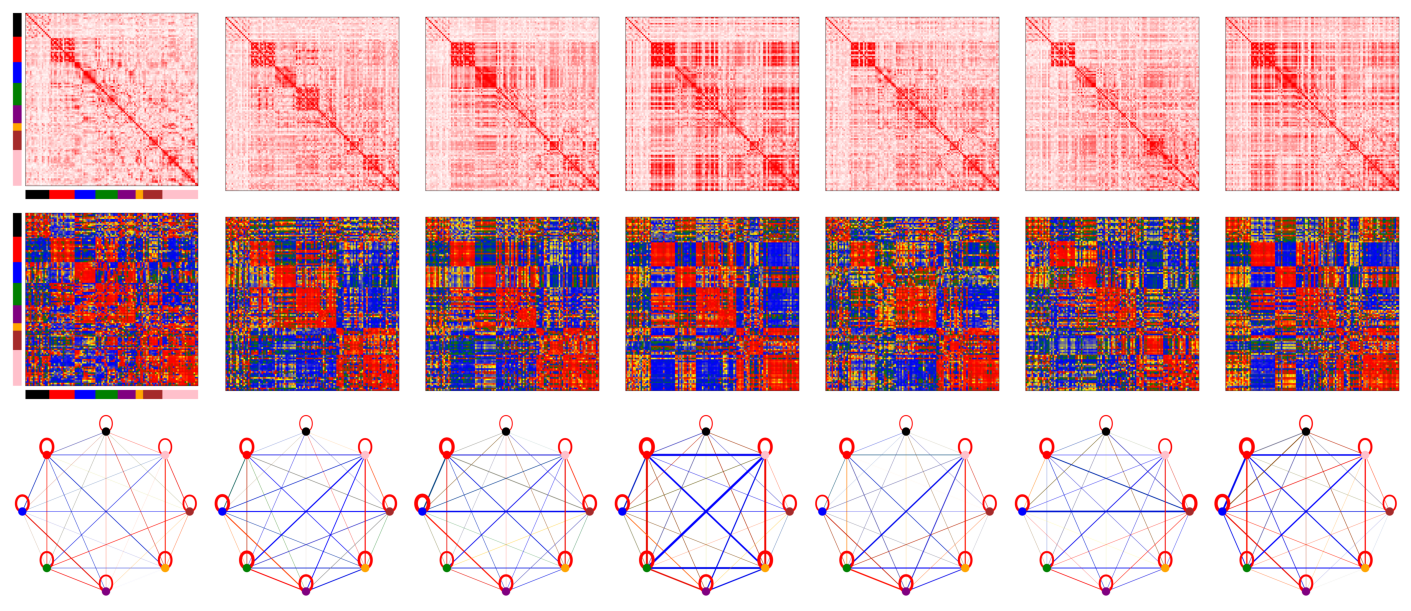

In [18]:
network_names2 = ['Subcort','Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','DMN']
fig,axs = plt.subplots(3,len(Zs),figsize=(2*len(Zs),6),layout='constrained',height_ratios=[1,1,1])
for i in range(len(Zs)):
    img3 = mpimg.imread('figures_tmp/all_tasks Complex ACG K=7, cluster '+str(i+1)+', magnitude.png')
    img4 = mpimg.imread('figures_tmp/all_tasks Complex ACG K=7, cluster '+str(i+1)+', angle.png')
    axs[0,i].imshow(img3)
    axs[0,i].axis('off')
    # axs[0,i].set_title('Cluster '+str(i+1)+', magnitude')
    axs[1,i].imshow(img4)
    axs[1,i].axis('off')
    # axs[1,i].set_title('Cluster '+str(i+1)+', angle')
    fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]), network_names=None)
    fig2.savefig('figures_tmp/all_tasks Complex ACG K=7, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
    plt.close()
    img = mpimg.imread('figures_tmp/all_tasks Complex ACG K=7, cluster '+str(i+1)+', graph.png')
    axs[2,i].imshow(img)
    axs[2,i].axis('off')
fig.savefig('figures/all_tasksCACG_rank25_K7_v2.png',dpi=300,bbox_inches='tight')

## K2 rank-25 solution

In [19]:
# params = np.load('../data/results/116_results/params/REST1REST2modelorder_realdata_Complex_ACG_K=2_rank=25.npy', allow_pickle=True).item()
# params['M'] = params['M'].numpy()
# Zs = []
# Zs_yeo = []
# for i in range(params['M'].shape[0]):
#     Zs.append(get_Z(params,sort=True,idx=i,model='Complex_ACG'))
#     Z2 = get_Z(params,sort=False,idx=i,model='ACG')
#     Z_yeo = avg_matrix_in_networks(Z2, network_indices)
#     Zs_yeo.append(Z_yeo)
#     # plotting.plot_connectome(adjacency_matrix=np.real(Z),node_coords=SchaeferTian116_coords[network_indices_concat,:],edge_threshold='99%',display_mode='lzr',node_size=10)

# for i in range(len(Zs)):
#     # plot_matrix(np.real(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', real',clim=(-0.5,0.5))
#     # plot_matrix(np.imag(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', imaginary',clim=(-0.5,0.5))
#     plot_matrix(np.abs(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', magnitude',cmap=cmap_bwr2,clim=(0,0.5))
#     plot_matrix(np.angle(Zs[i]), 'Complex ACG K=2, cluster '+str(i+1)+', angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))

In [20]:
# fig,axs = plt.subplots(len(Zs),3,figsize=(12,4*len(Zs)),layout='constrained',width_ratios=[1,1,1.4])
# for i in range(len(Zs)):
#     img3 = mpimg.imread('figures/Complex ACG K=2, cluster '+str(i+1)+', magnitude.png')
#     img4 = mpimg.imread('figures/Complex ACG K=2, cluster '+str(i+1)+', angle.png')
#     axs[i,0].imshow(img3)
#     axs[i,0].axis('off')
#     axs[i,0].set_title('Cluster '+str(i+1)+', magnitude')
#     axs[i,1].imshow(img4)
#     axs[i,1].axis('off')
#     axs[i,1].set_title('Cluster '+str(i+1)+', angle')
#     fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]))
#     fig2.savefig('figures/Complex ACG K=2, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
#     plt.close()
#     img = mpimg.imread('figures/Complex ACG K=2, cluster '+str(i+1)+', graph.png')
#     axs[i,2].imshow(img)
#     axs[i,2].axis('off')
# fig.savefig('figures/CACG_rank25_K2_v2.png',dpi=300,bbox_inches='tight')

In [21]:
# params['pi'].numpy()/np.sum(params['pi'].numpy())

## K3 rank-100 solution

In [22]:
params = np.load('../data/results/116_results/params/REST1REST2modelorder_realdata_Complex_ACG_K=3_rank=100.npy', allow_pickle=True).item()
params['M'] = params['M'].numpy()
Zs = []
Zs_yeo = []
for i in range(params['M'].shape[0]):
    Zs.append(get_Z(params,sort=True,idx=i,model='Complex_ACG'))
    Z2 = get_Z(params,sort=False,idx=i,model='ACG')
    Z_yeo = avg_matrix_in_networks(Z2, network_indices)
    Zs_yeo.append(Z_yeo)
    # plotting.plot_connectome(adjacency_matrix=np.real(Z),node_coords=SchaeferTian116_coords[network_indices_concat,:],edge_threshold='99%',display_mode='lzr',node_size=10)

for i in range(len(Zs)):
    # plot_matrix(np.real(Zs[i]), 'Complex ACG K=3, cluster '+str(i+1)+', real',clim=(-0.5,0.5))
    # plot_matrix(np.imag(Zs[i]), 'Complex ACG K=3, cluster '+str(i+1)+', imaginary',clim=(-0.5,0.5))
    plot_matrix(np.abs(Zs[i]), 'Complex ACG K=3, cluster '+str(i+1)+', magnitude',cmap=cmap_bwr2,clim=(0,0.5))
    plot_matrix(np.angle(Zs[i]), 'Complex ACG K=3, cluster '+str(i+1)+', angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))
torch.nn.functional.softmax(torch.tensor(params['pi']),dim=0).numpy()

/tmp/ipykernel_565457/3366324301.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.functional.softmax(torch.tensor(params['pi']),dim=0).numpy()


array([0.2309784 , 0.60626194, 0.16275966])

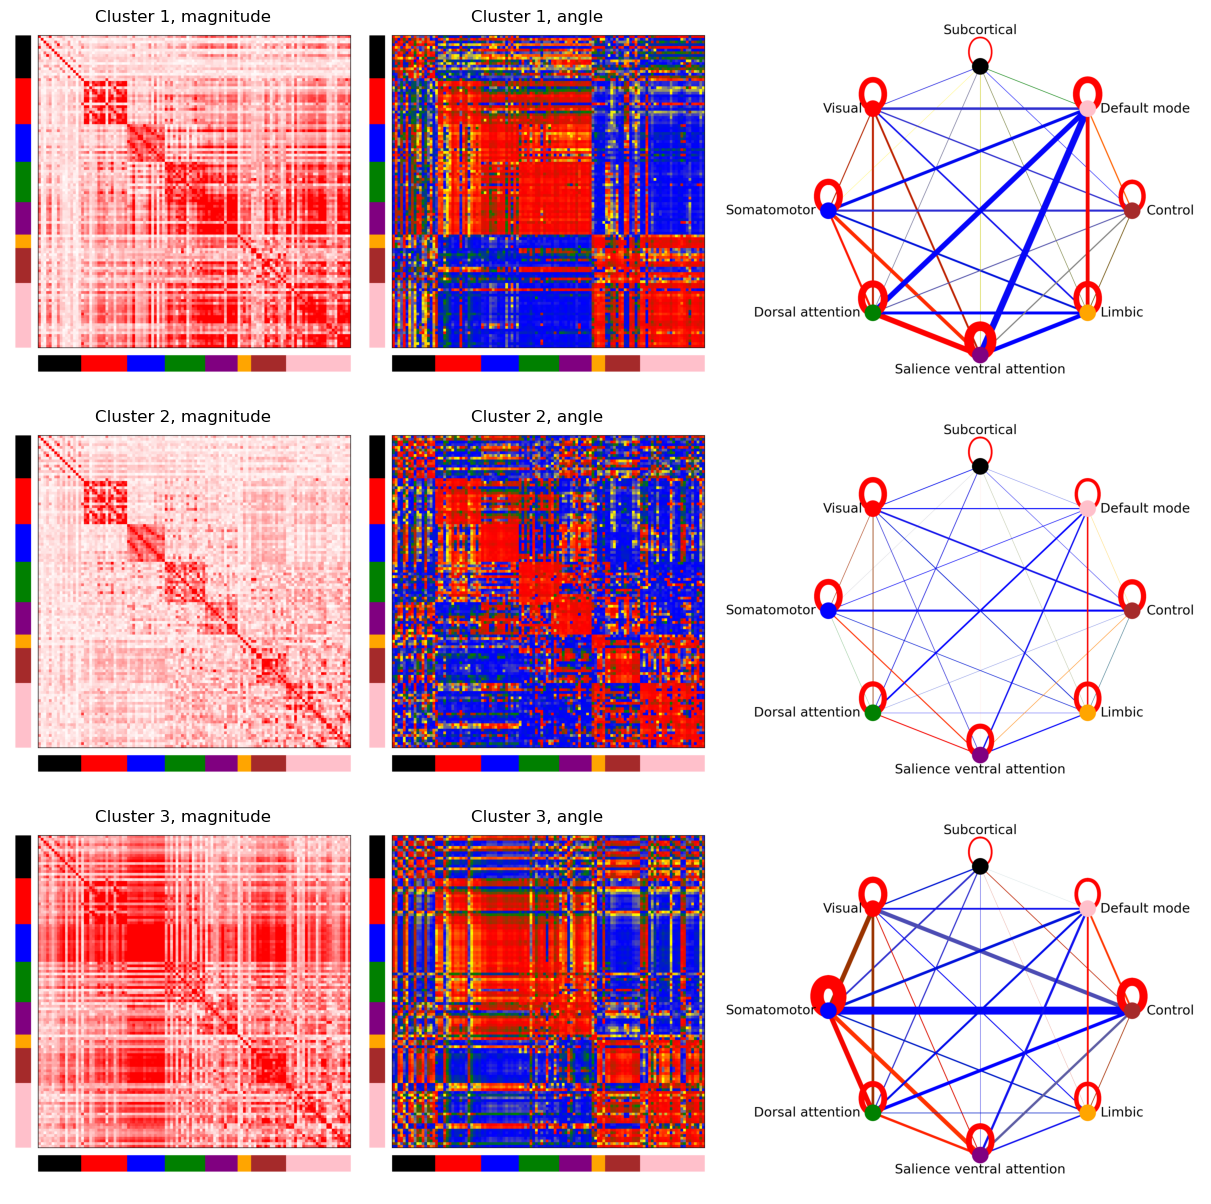

In [23]:
fig,axs = plt.subplots(len(Zs),3,figsize=(12,4*len(Zs)),layout='constrained',width_ratios=[1,1,1.4])
for i in range(len(Zs)):
    img3 = mpimg.imread('figures_tmp/Complex ACG K=3, cluster '+str(i+1)+', magnitude.png')
    img4 = mpimg.imread('figures_tmp/Complex ACG K=3, cluster '+str(i+1)+', angle.png')
    axs[i,0].imshow(img3)
    axs[i,0].axis('off')
    axs[i,0].set_title('Cluster '+str(i+1)+', magnitude')
    axs[i,1].imshow(img4)
    axs[i,1].axis('off')
    axs[i,1].set_title('Cluster '+str(i+1)+', angle')
    fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]), networks_names)
    fig2.savefig('figures_tmp/Complex ACG K=3, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
    plt.close()
    img = mpimg.imread('figures_tmp/Complex ACG K=3, cluster '+str(i+1)+', graph.png')
    axs[i,2].imshow(img)
    axs[i,2].axis('off')
fig.savefig('figures/CACG_rank25_K3_v2.png',dpi=300,bbox_inches='tight')

## K2 rank-25 solution (MOTORSOCIAL)

In [24]:
# # check order of clusters
# from helper_functions_realdata import load_fMRI_data
# params = np.load('../data/results/116_results/params/MOTORSOCIALmodelorder_realdata_Complex_ACG_K=2_rank=25.npy', allow_pickle=True).item()
# from PCMM.PCMMtorch import ACG
# CACG = ACG(p=116, K=2, rank=25,complex=True,params=params)
# data_file = '../data/processed/MOTORSOCIALfMRI_SchaeferTian116.h5'
# options = {}
# options['modelname'] = 'Complex_ACG'
# data_train,data_test1,data_test2 = load_fMRI_data(data_file,options=options,only_some_points=False)


In [25]:
# import torch
# posterior = CACG.posterior(torch.tensor(data_test2))
# # b=posterior.reshape(2,155,279).mean(axis=1)
# b=posterior.reshape(2,100,558).mean(axis=1)
# plt.plot(b.T)
# plt.legend(['Cluster 1','Cluster 2'])

In [26]:
# params = np.load('../data/results/116_results/params/MOTORSOCIALmodelorder_realdata_Complex_ACG_K=2_rank=25.npy', allow_pickle=True).item()
# params['M'] = params['M'].numpy()
# Zs = []
# Zs_yeo = []
# for i in range(params['M'].shape[0]):
#     Zs.append(get_Z(params,sort=True,idx=i,model='Complex_ACG'))
#     Z2 = get_Z(params,sort=False,idx=i,model='ACG')
#     Z_yeo = avg_matrix_in_networks(Z2, network_indices)
#     Zs_yeo.append(Z_yeo)
#     # plotting.plot_connectome(adjacency_matrix=np.real(Z),node_coords=SchaeferTian116_coords[network_indices_concat,:],edge_threshold='99%',display_mode='lzr',node_size=10)

# # revert the order!! To match with bar plots
# # Zs = Zs[::-1]
# # Zs_yeo = Zs_yeo[::-1]

# for i in range(len(Zs)):
#     # plot_matrix(np.real(Zs[i]), 'MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', real',clim=(-0.5,0.5))
#     # plot_matrix(np.imag(Zs[i]), 'MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', imaginary',clim=(-0.5,0.5))
#     plot_matrix(np.abs(Zs[i]), 'MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', magnitude',cmap=cmap_bwr2,clim=(0,0.5))
#     plot_matrix(np.angle(Zs[i]), 'MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))

# plot_matrix(np.abs(Zs[1]-Zs[0]), 'MOTORSOCIAL Complex ACG K=2, cluster 1-2, magnitude',clim=(-0.5,0.5))
# plot_matrix(np.angle(Zs[1]-Zs[0]), 'MOTORSOCIAL Complex ACG K=2, cluster 1-2, angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))

In [27]:
# fig,axs = plt.subplots(len(Zs),3,figsize=(12,4*len(Zs)),layout='constrained',width_ratios=[1,1,1.4])
# for i in range(len(Zs)):
#     img3 = mpimg.imread('figures/MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', magnitude.png')
#     img4 = mpimg.imread('figures/MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', angle.png')
#     axs[i,0].imshow(img3)
#     axs[i,0].axis('off')
#     axs[i,0].set_title('Cluster '+str(i+1)+', magnitude')
#     axs[i,1].imshow(img4)
#     axs[i,1].axis('off')
#     axs[i,1].set_title('Cluster '+str(i+1)+', angle')
#     fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]))
#     fig2.savefig('figures/MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
#     plt.close()
#     img = mpimg.imread('figures/MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', graph.png')
#     axs[i,2].imshow(img)
#     axs[i,2].axis('off')
# fig.savefig('figures/MOTORSOCIALCACG_rank25_K2_v1.png',dpi=300,bbox_inches='tight')

In [28]:
# fig,axs = plt.subplots(3,len(Zs),figsize=(8,4*len(Zs)),layout='constrained',height_ratios=[1,1,1.1])
# for i in range(len(Zs)):
#     img3 = mpimg.imread('figures/MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', magnitude.png')
#     img4 = mpimg.imread('figures/MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', angle.png')
#     axs[0,i].imshow(img3)
#     axs[0,i].axis('off')
#     axs[0,i].set_title('Cluster '+str(i+1)+', magnitude')
#     axs[1,i].imshow(img4)
#     axs[1,i].axis('off')
#     axs[1,i].set_title('Cluster '+str(i+1)+', angle')
#     fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]))
#     fig2.savefig('figures/MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
#     plt.close()
#     img = mpimg.imread('figures/MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', graph.png')
#     axs[2,i].imshow(img)
#     axs[2,i].axis('off')
# fig.savefig('figures/MOTORSOCIALCACG_rank25_K2_v2.png',dpi=300,bbox_inches='tight')

In [29]:
# params['pi'].numpy()/np.sum(params['pi'].numpy())

In [30]:
# params = np.load('../data/results/116_results/params/MOTORSOCIALmodelorder_realdata_Complex_ACG_K=2_rank=25_noGSR.npy', allow_pickle=True).item()
# params['M'] = params['M'].numpy()
# Zs = []
# Zs_yeo = []
# for i in range(params['M'].shape[0]):
#     Zs.append(get_Z(params,sort=True,idx=i,model='Complex_ACG'))
#     Z2 = get_Z(params,sort=False,idx=i,model='ACG')
#     Z_yeo = avg_matrix_in_networks(Z2, network_indices)
#     Zs_yeo.append(Z_yeo)
#     # plotting.plot_connectome(adjacency_matrix=np.real(Z),node_coords=SchaeferTian116_coords[network_indices_concat,:],edge_threshold='99%',display_mode='lzr',node_size=10)

# # revert the order!! To match with bar plots
# Zs = Zs[::-1]
# Zs_yeo = Zs_yeo[::-1]

# for i in range(len(Zs)):
#     # plot_matrix(np.real(Zs[i]), 'MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', real',clim=(-0.5,0.5))
#     # plot_matrix(np.imag(Zs[i]), 'MOTORSOCIAL Complex ACG K=2, cluster '+str(i+1)+', imaginary',clim=(-0.5,0.5))
#     plot_matrix(np.abs(Zs[i]), 'MOTORSOCIAL noGSR Complex ACG K=2, cluster '+str(i+1)+', magnitude',cmap=cmap_bwr2,clim=(0,1))
#     plot_matrix(np.angle(Zs[i]), 'MOTORSOCIAL noGSR Complex ACG K=2, cluster '+str(i+1)+', angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))

# plot_matrix(np.abs(Zs[1]-Zs[0]), 'MOTORSOCIAL noGSR Complex ACG K=2, cluster 1-2, magnitude',clim=(-0.5,0.5))
# plot_matrix(np.angle(Zs[1]-Zs[0]), 'MOTORSOCIAL noGSR Complex ACG K=2, cluster 1-2, angle',cmap=cyclic_cmap,clim=(-np.pi,np.pi))

In [31]:
# fig,axs = plt.subplots(len(Zs),3,figsize=(12,4*len(Zs)),layout='constrained',width_ratios=[1,1,1.4])
# for i in range(len(Zs)):
#     img3 = mpimg.imread('figures/MOTORSOCIAL noGSR Complex ACG K=2, cluster '+str(i+1)+', magnitude.png')
#     img4 = mpimg.imread('figures/MOTORSOCIAL noGSR Complex ACG K=2, cluster '+str(i+1)+', angle.png')
#     axs[i,0].imshow(img3)
#     axs[i,0].axis('off')
#     axs[i,0].set_title('Cluster '+str(i+1)+', magnitude')
#     axs[i,1].imshow(img4)
#     axs[i,1].axis('off')
#     axs[i,1].set_title('Cluster '+str(i+1)+', angle')
#     fig2=plot_graph_yeo(np.angle(Zs_yeo[i]),np.abs(Zs_yeo[i]))
#     fig2.savefig('figures/MOTORSOCIAL noGSR Complex ACG K=2, cluster '+str(i+1)+', graph.png',dpi=300,bbox_inches='tight')
#     plt.close()
#     img = mpimg.imread('figures/MOTORSOCIAL noGSR Complex ACG K=2, cluster '+str(i+1)+', graph.png')
#     axs[i,2].imshow(img)
#     axs[i,2].axis('off')
# fig.savefig('figures/MOTORSOCIAL_noGSR_CACG_rank25_K2_v2.png',dpi=300,bbox_inches='tight')

In [32]:
# params['pi'].numpy()/np.sum(params['pi'].numpy())